**Migration + Equilibrium tides + Obliquity evolution tutorial**

*Authors: Dang Pham, Michael Poon (equal contribution)*

In this tutorial, we produce an obliquity evolution for a 2-planet + star system that gets captured into near 3:2 mean motion resonance. Our setup is inspired by [Millholland+Laughlin2019](https://ui.adsabs.harvard.edu/abs/2019NatAs...3..424M/abstract) and [Lu+2023](https://ui.adsabs.harvard.edu/abs/2023arXiv230300006L/abstract), but modified to run in a few seconds. Changing the input parameters (to more realistic values) will yield results closer to those published, but require a much longer runtime (several hours to days).

Our simulation is set up in REBOUND, with migration and tidal dissipation effects implemented with REBOUNDx. 

The main changes we make from the original [ML19](https://ui.adsabs.harvard.edu/abs/2019NatAs...3..424M/abstract) setup are: 

(1) decreasing the total integration time (from 4 million years to 20,000 years)

(2) putting planets slightly closer to the 3:2 resonance and decreasing the damping timescales $\tau_{a,1}, \tau_{a,2}$ for faster resonance capture

(3) increasing the rate of tidal dissipation by artifically decreasing the tidal Q for the planet and star

(4) increasing the initial planet obliquity from ~0.5 degrees to 15 degrees

In [1]:
import rebound
import reboundx
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### 1. Migration

First, we set up the two planets and the star, according to [ML19](https://ui.adsabs.harvard.edu/abs/2019NatAs...3..424M/abstract).

In [2]:
# setup planet mass, eccentricity, radius in M_sun, AU units
planet_mass = 1.5017e-05 # 5 M_Earth
planet_ecc = 0.01
planet_radius = 0.0001 # 2.5 R_Earth
star_radius = 0.0046 # 1 R_Sun

In [24]:
# set up rebound
sim = rebound.Simulation()
sim.G = 1.
sim.add(m=1., r=star_radius, hash="star")
sim.add(m=planet_mass, a=0.17, 
        e=planet_ecc, r=planet_radius, hash="p1")
sim.add(m=planet_mass, a=0.225,
        e=planet_ecc, r=planet_radius, hash="p2")
sim.move_to_com()

# using WHFast with an integration timestep = planet period / 15.1234
ps = sim.particles
sim.integrator = "whfast"
sim.dt = ps[1].P / 15.1234

Next, we add semi-major axis damping forces (approximation of a type I disk migration damping).

In [25]:
# add migration forces with characteristic timescales
rebx = reboundx.Extras(sim)
mof = rebx.load_force("modify_orbits_forces")
τ1 = 0.125e6 * (2 * np.pi) # 5e6 in ML19
τ2 = τ1 / 1.1
ps[1].params["tau_a"] = -τ1
ps[2].params["tau_a"] = -τ2
rebx.add_force(mof)

Now, we integrate for 20,000 years, and turn off damping at 50,000 years.

In [26]:
%%time
# integrate until 100,000 years (c.f. ML19's 4 million years)
tmax = 2.e4
N_outputs = 1000

# set up arrays to store orbital elements
# 2 pi factors are to convert from yr to yr/2pi units

# here, we're integrating half of the way first
# then switch off migration forces
t_arr = np.linspace(0., 3/4*tmax, N_outputs // 2) * (2*np.pi)

# storing semimajor axis, eccentricity, and inclination
a = np.zeros((N_outputs,2))
ecc = np.zeros((N_outputs,2))
inc = np.zeros((N_outputs,2))

for i, t in enumerate(t_arr):
    sim.integrate(t, exact_finish_time=1)
    
    ps = sim.particles
    a[i] = [ps[1].a, ps[2].a]
    ecc[i] = [ps[1].e, ps[2].e]
    inc[i] = [ps[1].inc, ps[2].inc]

# switch off migration
ps[1].params["tau_a"] = np.inf
ps[2].params["tau_a"] = np.inf

# integrate the rest of the way
t_arr = np.linspace(3/4*tmax, tmax, N_outputs // 2) * (2*np.pi)

for i, t in enumerate(t_arr):
    sim.integrate(t, exact_finish_time=1)

    ps = sim.particles
    a[i + N_outputs // 2] = [ps[1].a, ps[2].a]
    ecc[i + N_outputs // 2] = [ps[1].e, ps[2].e]
    inc[i + N_outputs // 2] = [ps[1].inc, ps[2].inc]

CPU times: user 2.24 s, sys: 6 ms, total: 2.24 s
Wall time: 2.24 s


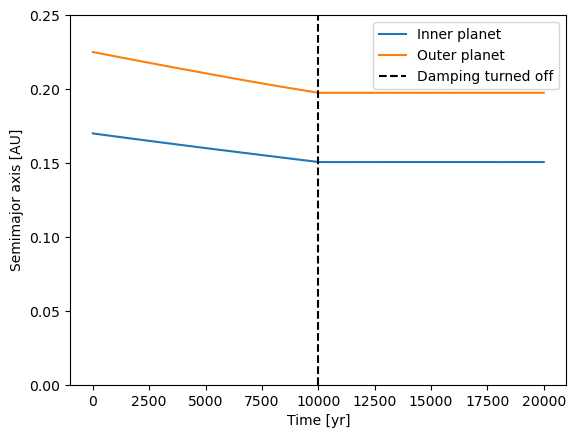

In [27]:
# make time array for plotting
t_plot = list(np.linspace(0., tmax / 2, N_outputs // 2)) + list(np.linspace(tmax / 2, tmax, N_outputs // 2))

plt.plot(t_plot, a[:,0], label="Inner planet")
plt.plot(t_plot, a[:,1], label="Outer planet")
plt.axvline(tmax / 2, color="k", linestyle="--", label="Damping turned off")
plt.ylim([0., 0.25])
plt.ylabel("Semimajor axis [AU]")
plt.xlabel("Time [yr]")
plt.legend()
plt.show()

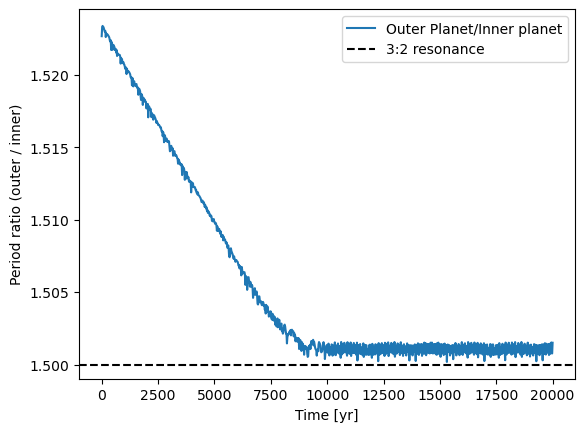

In [28]:
plt.plot(t_plot, (a[:,1] / a[:,0])**(3./2.), label="Outer Planet/Inner planet")
plt.ylabel("Period ratio (outer / inner)")
plt.xlabel("Time [yr]")
plt.axhline(1.5, color="k", linestyle="--", label="3:2 resonance")
plt.legend()
plt.show()

We can see here that the planets get captured into a 3:2 resonance at about 10,000 years.

### 2. Migration with equilibrium tides and obliquity evolution

In this section, we implement the effect of equilibrium tides to excite obliquity evolution. First, we set up the basic simulation with migration forces as above.

In [33]:
# set up rebound
sim = rebound.Simulation()
sim.G = 1.
sim.add(m=1., r=star_radius, hash="star")
sim.add(m=planet_mass, a=0.17, 
        e=planet_ecc, r=planet_radius, hash="p1")
sim.add(m=planet_mass, a=0.225,
        e=planet_ecc, r=planet_radius, hash="p2")
sim.move_to_com()

# using WHFast with an integration timestep = planet period / 15.1234
ps = sim.particles
sim.integrator = "whfast"
sim.dt = ps[1].P / 15.1234

# add migration forces with characteristic timescales
rebx = reboundx.Extras(sim)
mof = rebx.load_force("modify_orbits_forces")
τ1 = 0.125e6 * (2 * np.pi) # 5e6 in ML19
τ2 = τ1 / 1.1
ps[1].params["tau_a"] = -τ1
ps[2].params["tau_a"] = -τ2
rebx.add_force(mof)

In [34]:
# helper function to calculate planet obliquity given
# planet spin axis and orbit normal
def angle_between_vecs(vec1, vec2):
    """ Calculate the angle between two vectors"""
    dot_prod = np.dot(vec1, vec2)
    norm_prod = np.linalg.norm(vec1) * np.linalg.norm(vec2)
    return np.arccos(dot_prod / norm_prod)

Next, we set up the equilibrium tides.

In [35]:
sf = rebx.load_force("tides_spin")
rebx.add_force(sf)

# Star parameters
# Stellar rotation period = 20 days
Prot_star = 20 * (2*np.pi)# days
C_star = 0.07 # normalized moment of inertia
Q_star = 1e4 # tidal quality factor for the star, should be 1e6
ps[0].params['Omega'] = rebound.spherical_to_xyz(magnitude=(2*np.pi)/(20/365), theta=0., phi=0.)
ps[0].params['I'] = C_star * ps[0].m * ps[0].r**2
ps[0].params['tau'] = 1./(2.* Q_star * ps[1].n)

# Planet parameters
C_planet = 0.25 # normalized moment of inertia
Prot_planet1 = 5 * (2*np.pi)# days
initial_obliquity = 15 # degrees, should be 1 degrees
Q_planet = 5e2 # should be 1e4 from ML19
ps[1].params['Omega'] = rebound.spherical_to_xyz(magnitude=(2*np.pi)/(Prot_planet1/365), theta=np.radians(initial_obliquity), phi=0.)
ps[1].params['I'] = C_planet * ps[1].m * ps[1].r**2
ps[1].params['tau'] = 1./(2.* Q_planet * ps[1].n)

Prot_planet2 = 3 * (2*np.pi) #days
ps[2].params['Omega'] = rebound.spherical_to_xyz(magnitude=(2*np.pi)/(Prot_planet2/365), theta=np.radians(initial_obliquity), phi=0.)
ps[2].params['I'] = C_planet * ps[2].m * ps[2].r**2
ps[2].params['tau'] = 1./(2.* Q_planet * ps[2].n)

# Set k2 Love numbers so planets feel tides and deform from perfect spheres
ps[0].params['k2'] = 0.07
ps[1].params['k2'] = 0.4
ps[2].params['k2'] = 0.4

In [36]:
# initialize spin ODEs
rebx.initialize_spin_ode(sf)

Now, let's integrate up to 20,000 years ([ML19](https://ui.adsabs.harvard.edu/abs/2019NatAs...3..424M/abstract) runs for 4 million years, but that is quite computationally intensive).

In [37]:
%%time
# integrate until 20,000 years
tmax = 2.e4
N_outputs = 100

# set up arrays to store orbital elements
# 2 pi factors are to convert from yr to yr/2pi units

# here, we're integrating half of the way first
# then switch off migration forces
t_arr = np.linspace(0., tmax, N_outputs) * (2*np.pi)

# storing semimajor axis, eccentricity, inclination, and obliquity
a = np.zeros((N_outputs,2))
ecc = np.zeros((N_outputs,2))
inc = np.zeros((N_outputs,2))
obliquity = np.zeros((N_outputs,2))

for i, t in enumerate(t_arr):
    sim.integrate(t)

    ps = sim.particles
    a[i] = [ps[1].a, ps[2].a]
    ecc[i] = [ps[1].e, ps[2].e]
    inc[i] = [ps[1].inc, ps[2].inc]

    Omega_planet1 = ps[1].params["Omega"]
    Omega_planet2 = ps[2].params["Omega"]
    orbit_normal1 = ps[1].hvec
    orbit_normal2 = ps[2].hvec
    theta1 = angle_between_vecs(Omega_planet1, orbit_normal1)
    theta2 = angle_between_vecs(Omega_planet2, orbit_normal2)

    obliquity[i] = [np.degrees(theta1), np.degrees(theta2)]

# switch off migration
ps[1].params["tau_a"] = np.inf
ps[2].params["tau_a"] = np.inf

CPU times: user 8.78 s, sys: 14.4 ms, total: 8.79 s
Wall time: 8.81 s


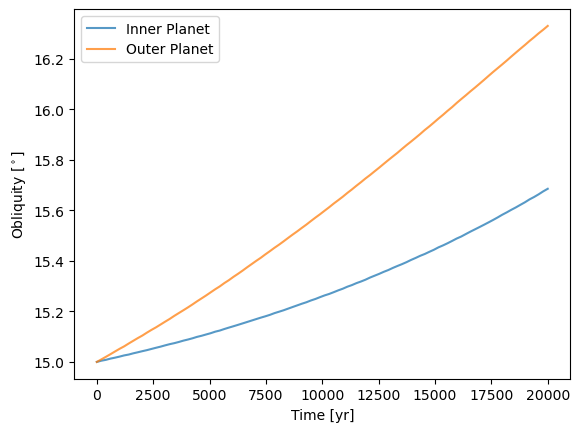

In [38]:
plt.plot(t_arr / (2*np.pi), obliquity[:,1], '-', alpha=0.75, label="Inner Planet")
plt.plot(t_arr / (2*np.pi), obliquity[:,0], '-', alpha=0.75, label="Outer Planet")
plt.xlabel("Time [yr]")
plt.ylabel(r"Obliquity [$^\circ$]")
plt.legend()
plt.show()

With the right parameters, we could compare this with Figure 3 of [ML19](https://ui.adsabs.harvard.edu/abs/2019NatAs...3..424M/abstract) and Figure 3 of [Lu+2023](https://ui.adsabs.harvard.edu/abs/2023arXiv230300006L/abstract), and see that the obliquity evolution is similar. However, we modify our setup for quick runtime and show that both planet obliquities can get excited. Play around with the input parameters described above to explore different behaviours. More physical systems will likely take several hours to days in runtime.

### 3. Where to go from here?

Possible future directions with planet obliquities using REBOUND/REBOUNDx:

In our solar system: Saturn's nonzero planet obliquity of ~27 degrees is thought to be caused by gravitational perturbations by Neptune ([Ward+Hamilton2004](https://ui.adsabs.harvard.edu/abs/2004AJ....128.2501W/abstract)). This is because of the similarity between the precession period of Saturn's spin axis and the precession period of Neptune's inclined orbit plane, which could imply a spin-orbit resonance interaction. It would be interesting to reproduce this.

Outside our solar system: Of the few observationally constrained planet obliquities (i.e. [Bryan+2020a](https://ui.adsabs.harvard.edu/abs/2020AJ....159..181B/abstract), [Bryan+2021](https://ui.adsabs.harvard.edu/abs/2021AJ....162..217B/abstract)), the planetary-mass companion with the smallest semi-major axis is ~50 AU. In the setup we follow in [ML19](https://ui.adsabs.harvard.edu/abs/2019NatAs...3..424M/abstract), the planets are at < 1 AU. It would be interesting to test how far our obliquity evolution can happen if different parameters were fine-tined (i.e. tidal dissipation rate, MMR, inclinations, eccentricities, semi-major axis).